In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
from astropy import units as u
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time

from astroplan.plots import plot_airmass, plot_sky, plot_sky_24hr, plot_finder_image
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

from astroplan import Observer

from panoptes.pocs.scheduler.dispatch import Scheduler
from panoptes.pocs.scheduler.constraint import AlreadyVisited, Duration, MoonAvoidance, Altitude
from panoptes.pocs.scheduler.observation import Observation
from panoptes.utils.config import load_config
from panoptes.utils.config import client
from panoptes.utils.config import server
from panoptes.utils import listify
from panoptes.utils.horizon import Horizon

import logging

config = load_config("/var/panoptes/POCS/conf_files/pocs.yaml")


In [81]:
# Get a location
loc = config['location']
location = EarthLocation(lon=loc['longitude'], lat=loc['latitude'], height=loc['elevation'])
print(location)

#Get an observer at the location
observer = Observer(location=location)
print(observer)

# Create a horizon line
points = [
    [[40, 30], [40, 75]],  # From 30°-75° east there is an obstruction at 40° altitude
    [[50, -60], [40, -30]] # From 60°-30° west there is an obstruction sloping from 50° to 40° altitude
]
horizon = Horizon(points)

# Get the night hours (you can use observer.tonight())
times = observer.tonight(horizon=-18 * u.degree)
start_of_night = times[0]
end_of_night = times[1]
# start_of_night = Time('2016-08-13 10:00:00')
# end_of_night = Time('2016-08-13 16:00:00')

(-5478046.23697881, -2487258.02090963, 2120912.92046144) m
<Observer: location (lon, lat, el)=(-155.58 deg, 19.539999999999992 deg, 3400.0000000009422 m),
    timezone=<UTC>>


In [70]:
simple_fields_file = config['directories']['targets'] + '/simple.yaml'
print(simple_fields_file)

# Simple constraint to maximize duration above a certain altitude
constraints = [AlreadyVisited(), MoonAvoidance(), Duration(30 * u.deg)]
constraints = [AlreadyVisited(), Altitude(horizon), MoonAvoidance(), Duration(30 * u.deg)]

# Create a scheduler
scheduler = Scheduler(observer, fields_file=simple_fields_file, constraints=constraints)

/var/panoptes/POCS/resources/targets/simple.yaml


In [71]:
for obs in scheduler.observations.values():
    print(obs)

Kepler 488: 120.0 s exposures in blocks of 10, minimum 60, priority 125
Kepler 1100: 120.0 s exposures in blocks of 10, minimum 60, priority 125
KIC 8462852: 120.0 s exposures in blocks of 10, minimum 60, priority 200
HD 23630: 120.0 s exposures in blocks of 10, minimum 60, priority 100
HD 189733: 100.0 s exposures in blocks of 10, minimum 60, priority 105
HD 209458: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 140: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 104: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 44: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 2: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 24: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 77: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 33: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 43: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 36: 120.0 s 

In [72]:
# Get the best observations for the given time
# show_all returns entire list along with merit
best = scheduler.get_observation(time=start_of_night, show_all=True)

for b in listify(best):
    print("Field: {:12s} Merit: {}".format(b[0], b[1])) #What is merit?

Field: HAT-P-36     Merit: 220.750824791559
Field: M5           Merit: 112.68701939949474


In [73]:
scheduler.current_observation.field.coord.equinox

<Time object: scale='tt' format='jyear_str' value=J2000.000>

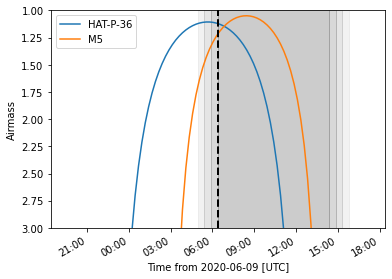

In [74]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, start_of_night, 
             brightness_shading=True)
        
plt.axvline(start_of_night.plot_date, lw=2, ls='--', c='k')    
plt.legend(loc=2)
plt.show()

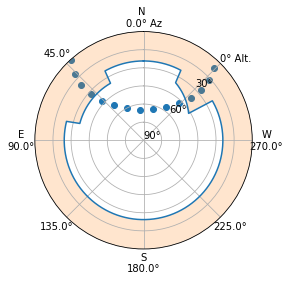

In [75]:
ax = plot_sky_24hr(scheduler.current_observation.field, scheduler.observer, start_of_night)

# Show horizon

# Scale from 0 - 100 where 100 = 0° and 0 = 90°
y = (100 - (horizon.horizon_line * 100) / 90)
# 0 - 2π spread across 360
x = np.linspace(0, 2 * np.pi, 360)
ax.plot(x, y)
ax.fill_between(x, y, 100, alpha=0.2)

plt.show()

In [76]:
# Set a later time to start
t2 = end_of_night - 3 * u.hour

# Get the best observation for the given time
# show_all returns entire list along with merit
best = scheduler.get_observation(show_all=True, time=t2)

for b in listify(best):
    print("Field: {:12s} Merit: {}".format(b[0], b[1]))

Field: Tres 3       Merit: 242.69637616298095
Field: HD 189733    Merit: 237.83078369766338


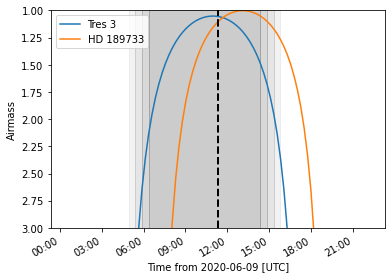

In [77]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, t2, 
             brightness_shading=True)
plt.axvline(t2.plot_date, lw=2, ls='--', c='k')
plt.legend(loc=2)
plt.show()

## Entire Night Simulation

Now let's simulate going through the whole evening

In [78]:
# Start at the beginning of the night
next_time = start_of_night
print("Start of night at {}".format(start_of_night.isot))

# Reset scheduler
# Create a scheduler
scheduler = Scheduler(observer, fields_file=simple_fields_file, constraints=constraints)

while (next_time < end_of_night):    
    # Only get new target if we have met min_nexp for observation
    if (scheduler.current_observation is None) or (scheduler.current_observation.current_exp >= scheduler.current_observation.min_nexp):
        
        print("Getting new observation at {}".format(next_time.isot))
        new_obs = scheduler.get_observation(time=next_time)
        
    if scheduler.current_observation is not None:

        if (scheduler.current_observation.current_exp_num < scheduler.current_observation.min_nexp):
            obs_duration = scheduler.current_observation.minimum_duration
           
            # Fake the exposure count
            scheduler.current_observation.current_exp = scheduler.current_observation.min_nexp
        else:
            obs_duration = scheduler.current_observation.set_duration
    
            # Fake the exposure count
            scheduler.current_observation.current_exp += scheduler.current_observation.exp_set_size

        print("\tWill observe {} with merit of {:0.5f} for {}".format(
                    scheduler.current_observation.name, 
                    scheduler.current_observation.merit, 
                    obs_duration))
        print("\t{} of {}".format(scheduler.current_observation.current_exp, 
                                  scheduler.current_observation.min_nexp))
                
    next_time = next_time + obs_duration
    
print("End of night at {}".format(end_of_night.isot))

Start of night at 2020-06-10T06:23:46.883
Getting new observation at 2020-06-10T06:23:46.883


	Will observe HAT-P-36 with merit of 220.75082 for 7200.0 s
	60 of 60
Getting new observation at 2020-06-10T08:23:46.883
	Will observe Tres 3 with merit of 242.30770 for 7200.0 s
	60 of 60
Getting new observation at 2020-06-10T10:23:46.883
	Will observe KIC 8462852 with merit of 474.35685 for 7200.0 s
	60 of 60
Getting new observation at 2020-06-10T12:23:46.883
	Will observe KIC 8462852 with merit of 474.35685 for 7200.0 s
	60 of 60
End of night at 2020-06-10T14:19:53.143


In [63]:
time = Time('2016-08-13 8:00:00')
scheduler.get_observation(time=time)
print(scheduler.current_observation)

time = Time('2016-08-13 15:00:00')
scheduler.get_observation(time=time)
print(scheduler.current_observation)

time = Time('2016-08-13 17:30:00')
scheduler.get_observation(time=time)
print(scheduler.current_observation)

HD 209458: 120.0 s exposures in blocks of 10, minimum 60, priority 100
EPIC-211089792: 120.0 s exposures in blocks of 10, minimum 60, priority 100
HAT-P-20: 120.0 s exposures in blocks of 10, minimum 60, priority 100


In [64]:
print(scheduler.current_observation)

HAT-P-20: 120.0 s exposures in blocks of 10, minimum 60, priority 100
